# Test - Mondrian Forest Regression

This notebook contains a simple test of the regression functions of the Modrian Forest code written by B. Lakshminarayanan. Specifically it constructs a toy dataset and runs the MF code, testing the uncertainty predictions. In addition, we run a sklearn Random Forest and Extra Trees Classifier for comparison.

In short, I find the MF code indeed produces similar  performance as the other random forests, however it is strikingly slower compared to the batch counterparts. While Online RF models may indeed be very slow, this is much slower that desired for this size/dimension data. Not sure if code refactoring would be a game changer, I suspect yes.

In addition, the uncertainty estimates (while perhaps better calibrated as the paper claims) do not seem to be very accurate under the gaussian assumption.

## Toy data set

Below is the toy dataset used, cubic in x and y and sinusoidal in y.

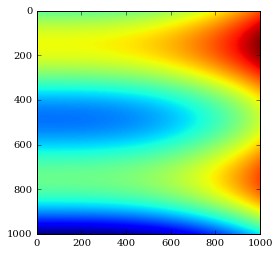

In [101]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rc
rc("text", usetex=False)

np.random.seed(12345)
scl = 10
XX, YY = np.meshgrid(np.linspace(0, 1, 1000) * scl, np.linspace(0, 1, 1000) * scl)
VV = XX**3 - YY ** 3 + 100 * np.median(YY) * np.sin(YY)
pl.imshow(VV)
pl.show()

## Train and test definitions

For this simple example, we will take 1000 training examples and evaluation on 300 test examples.

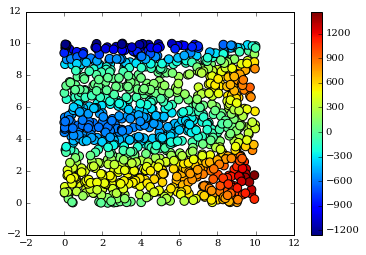

In [102]:
np.random.seed(12345)
ind = np.random.permutation(XX.size)
Ntrain = 1000
Ntest = 300
train_ind = ind[:Ntrain]
test_ind = ind[-Ntest:]
x_train = np.vstack((XX.ravel()[train_ind], YY.ravel()[train_ind])).T
v_train = VV.ravel()[train_ind]
x_test = np.vstack((XX.ravel()[test_ind], YY.ravel()[test_ind])).T
v_test = VV.ravel()[test_ind]
points = pl.scatter(x_train[:, 0], x_train[:, 1], c=v_train, s=75)
pl.colorbar(points)

In [103]:
# make data dict to follow MF codebase
def make_data(xtrain, xtest, ytrain, ytest):
    data = {}
    data['n_dim'] = xtrain.shape[1]
    data['x_train'] = xtrain
    data['y_train'] = ytrain
    data['n_train'] = xtrain.shape[0]
    data['x_test'] = xtest
    data['y_test'] = ytest
    data['n_test'] = xtest.shape[0]
    data['n_class'] = 1
    data['is_sparse'] = 0
    data['train_ids_partition'] = {}
    
    data['train_ids_partition']['current'] = {0:np.arange(xtrain.shape[0])}
    data['train_ids_partition']['cumulative'] = {0:np.arange(xtrain.shape[0])}
    return data
data = make_data(x_train.copy(), x_test.copy(), v_train.copy(), v_test.copy())

In [104]:
from time import time
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

np.random.seed(12345)
def run_regressor(rgr, data):
    """
    Run a sklearn regressor, return time and score
    """
    t0 = time()
    rgr.fit(data['x_train'].copy(), data['y_train'].copy())
    score = mean_squared_error(rgr.predict(data['x_test'].copy()), data['y_test'].copy())
    run_time = time()-t0
    return run_time, score

rf_time, rf_score = run_regressor(RandomForestRegressor(10, min_samples_leaf=5), data)
et_time, et_score = run_regressor(ExtraTreesRegressor(10, min_samples_leaf=5), data)

## Punking the command line

I do not personally enjoy the command line interface of the MF code.  Below is a class containing the settings necessary to run the code.

In [105]:
class ParamSettings(object):
    def __init__(self):
        self.dataset = 'toy'
        self.normalize_features = 1
        self.select_features = 0
        self.optype = 'real'
        self.data_path = './process_data/'
        self.debug = 0
        self.op_dir = 'results'
        self.tag = ''
        self.save = 0
        self.verbose = 1
        self.init_id = 1
        self.n_mondrians = 10
        self.budget = -1 # -1 sets lifetime to inf
        self.discount_factor = 10
        self.n_minibatches = 1
        self.draw_mondrian = 0
        self.smooth_hierarchically = 0 # setting to zero seems to make regression work
        self.store_every = 0
        self.bagging = 0
        self.min_samples_split = 10
        self.name_metric = 'mse'
        
        if self.optype == 'class':
            self.alpha = 0    # normalized stable prior
            assert self.smooth_hierarchically
            
        if self.budget < 0:
            self.budget_to_use = np.inf
        else:
            self.budget_to_use = settings.budget
        
settings = ParamSettings()

# Run the MF

This code is mostly copied from modrianforest_demo.py in this repo, with some small modifications for this notebook

from src.mondrianforest_utils import load_data, reset_random_seed, precompute_minimal
from src.mondrianforest import process_command_line, MondrianForest


In [106]:
from src.mondrianforest_utils import load_data, reset_random_seed, precompute_minimal
from src.mondrianforest import process_command_line, MondrianForest
np.random.seed(12345)

# data loading and cache
param, cache = precompute_minimal(data, settings)


# begin training and prediction, timing the overall process
mf = MondrianForest(settings, data)
print '\nminibatch\tmetric_train\tmetric_test\tnum_leaves'
t0=time()

# loop over minibatches
for idx_minibatch in range(settings.n_minibatches):
    train_ids_current_minibatch = data['train_ids_partition']['current'][idx_minibatch]
    if idx_minibatch == 0:
        # Batch training for first minibatch
        mf.fit(data, train_ids_current_minibatch, settings, param, cache)
    else:
        # Online update
        mf.partial_fit(data, train_ids_current_minibatch, settings, param, cache)

    weights_prediction = np.ones(settings.n_mondrians) * 1.0 / settings.n_mondrians
    train_ids_cumulative = data['train_ids_partition']['cumulative'][idx_minibatch]
    pred_forest_train, metrics_train = \
        mf.evaluate_predictions(data, data['x_train'][train_ids_cumulative, :], \
        data['y_train'][train_ids_cumulative], \
        settings, param, weights_prediction, False)
    pred_forest_test, metrics_test = \
        mf.evaluate_predictions(data, data['x_test'], data['y_test'], \
        settings, param, weights_prediction, False)
    name_metric = settings.name_metric     # acc or mse
    metric_train = metrics_train[name_metric]
    metric_test = metrics_test[name_metric]
    tree_numleaves = np.zeros(settings.n_mondrians)
    for i_t, tree in enumerate(mf.forest):
        tree_numleaves[i_t] = len(tree.leaf_nodes)
    forest_numleaves = np.mean(tree_numleaves)
    print '%9d\t%.3f\t\t%.3f\t\t%.3f' % (idx_minibatch, metric_train, metric_test, forest_numleaves)
mf_time = time() - t0



minibatch	metric_train	metric_test	num_leaves
log_prob (using Gaussian approximation) = -5.854902
log_prob (using mixture of Gaussians) = -5.394751
log_prob (using Gaussian approximation) = -6.017767
log_prob (using mixture of Gaussians) = -5.757583
        0	2880.195		4859.337		196.800


# Prediction Summary

The MSE from MF worse than ERT and RF, but within a reasonable ballpark.

In [108]:
print 'RF time, mse = %0.2f, %0.2f' % (rf_time, rf_score)
print 'ET time, mse = %0.2f, %0.2f' % (et_time, et_score)
print 'MF time, mse = %0.2f, %0.2f' % (mf_time, metric_test)

RF time, mse = 0.06, 2929.90
ET time, mse = 0.03, 3945.34
MF time, mse = 1.00, 4859.34


# Uncertainy Summary

The number of predictions within 1sigma of the true value is overly high, indicating the variance is over estimated

In [109]:
chi = np.abs(v_test - pred_forest_test['pred_mean']) / np.sqrt(pred_forest_test['pred_var']) 
print 'Percentage within 1sigma = %0.2f' % (1. * np.where(chi < 1)[0].size / v_test.size)

Percentage within 1sigma = 0.99
